In [1]:
# libraires nécessaires
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, classification_report, average_precision_score

In [2]:
def oversampling(donnees,nom_var):
    data=donnees.copy()
    indexval1=data.index[data[nom_var]==1]
    indexval0=data.index[data[nom_var]==0]
    #tirage aléatoire avec remise des valeurs du groupe 1
    newliste=np.random.choice(indexval1,indexval0.shape[0],replace=True).astype('int32')
    newliste1=[]
    for val in newliste:
        newliste1.append(np.min(np.where(data.index==val)))
    data_over=data.take(newliste1)
    data_over=pd.concat([data_over,data.loc[indexval0]],axis=0)
    return(data_over)

In [3]:
data_train = pd.read_table('train_set.csv',sep=',',header=0,index_col=0)
data_test = pd.read_table('val_set.csv',sep=',',header=0,index_col=0)
data_train = oversampling(data_train,'assur_caravane')
data_test = oversampling(data_test,'assur_caravane')
y_train = data_train['assur_caravane']
y_test = data_test['assur_caravane']
data_train = data_train[['nbmaisons', 'nbpers_au_foyer','nb_auto','nb_incendie',
               'nb_RC_entreprise', 'nb_camion_livraison','nb_remorque']]
data_test = data_test[['nbmaisons', 'nbpers_au_foyer','nb_auto','nb_incendie',
               'nb_RC_entreprise', 'nb_camion_livraison','nb_remorque']]
data_train.head(10)

,nbmaisons,nbpers_au_foyer,nb_auto,nb_incendie,nb_RC_entreprise,nb_camion_livraison,nb_remorque
cle,,,,,,,
3236,1,2,1,1,0,0,0
2223,1,3,1,1,0,0,0
4344,1,2,1,1,0,0,0
2457,1,2,1,0,0,0,0
2153,1,2,2,1,0,0,0
2153,1,2,2,1,0,0,0
1628,1,2,2,1,0,0,0
5308,1,3,1,1,0,0,0
4422,1,3,1,1,0,0,0


In [4]:
data_test.head(10)

,nbmaisons,nbpers_au_foyer,nb_auto,nb_incendie,nb_RC_entreprise,nb_camion_livraison,nb_remorque
cle,,,,,,,
2745,1,2,0,1,0,0,0
627,1,3,1,0,0,0,0
5171,2,4,1,1,0,0,0
2277,2,4,0,1,0,0,0
2954,1,3,1,1,0,0,0
925,2,4,0,1,0,0,0
2096,1,3,2,1,0,0,0
5185,1,2,1,0,0,0,0
5176,1,3,1,1,0,0,0


In [5]:
#centrage et réduction de la base d'apprentissage
from sklearn.preprocessing import StandardScaler
data_scale=StandardScaler()
data_scale.fit(data_train)
datacr_train=data_scale.transform(data_train)
datacr_test=data_scale.transform(data_test)

In [6]:
from sklearn.neighbors import KNeighborsClassifier
data_clf=KNeighborsClassifier() #k=5 par défaut
data_clf.fit(datacr_train,y_train)

pred_train=data_clf.predict(datacr_train)
pred_test=data_clf.predict(datacr_test)

In [7]:
pred_test

array([1, 1, 1, ..., 0, 1, 1])

In [8]:
exactitude_train=np.sum(pred_train==y_train)/pred_train.shape[0]
print(exactitude_train)
exactitude_test=np.sum(pred_test==y_test)/pred_test.shape[0]
print(exactitude_test)

0.561401506505364
0.5114364135407137


In [9]:
#matrice de confusion
from sklearn.metrics import confusion_matrix, classification_report
#confusion_matrix(cible,predite)
print(confusion_matrix(y_train,pred_train))
print(confusion_matrix(y_test,pred_test))

[[ 538 3843]
 [   0 4381]]
[[130 963]
 [105 988]]


In [10]:
#precision, rappel, f1 score
print(classification_report(y_train,pred_train))
print(classification_report(y_test,pred_test))

              precision    recall  f1-score   support

           0       1.00      0.12      0.22      4381
           1       0.53      1.00      0.70      4381

    accuracy                           0.56      8762
   macro avg       0.77      0.56      0.46      8762
weighted avg       0.77      0.56      0.46      8762

              precision    recall  f1-score   support

           0       0.55      0.12      0.20      1093
           1       0.51      0.90      0.65      1093

    accuracy                           0.51      2186
   macro avg       0.53      0.51      0.42      2186
weighted avg       0.53      0.51      0.42      2186



In [11]:
#choix optimal du seuil
from sklearn.metrics import precision_score, recall_score, auc, f1_score, roc_curve
exac_train=[]
preci_train=[]
rappel_train=[]
f1score_train=[]
auc_train=[]
exac_test=[]
preci_test=[]
rappel_test=[]
f1score_test=[]
auc_test=[]
for i in range(1,21):
    data_clf=KNeighborsClassifier(n_neighbors=i)
    data_clf.fit(datacr_train,y_train)
    #apprentissage
    pred_train=data_clf.predict(datacr_train)
    proba_train=data_clf.predict_proba(datacr_train)
    exactitude_train=np.sum(y_train==pred_train)/datacr_train.shape[0]
    precision_train=precision_score(y_train,pred_train)
    rap_train=recall_score(y_train,pred_train)
    fpr_train,tpr_train,seuil_train=roc_curve(y_train,proba_train[:,1],pos_label=1) #1 pour assur_caravane
    aire_train=auc(fpr_train,tpr_train)
    f1_train=f1_score(y_train,pred_train)
    exac_train.append(exactitude_train)
    preci_train.append(precision_train)
    rappel_train.append(rap_train)
    f1score_train.append(f1_train)
    auc_train.append(aire_train)
    
    #validation
    pred_test=data_clf.predict(data_test)
    proba_test=data_clf.predict_proba(data_test)
    exactitude_test=np.sum(y_test==pred_test)/data_test.shape[0]
    precision_test=precision_score(y_test,pred_test)
    rap_test=recall_score(y_test,pred_test)
    f1_test=f1_score(y_test,pred_test)
    fpr_test,tpr_test,seuil_test=roc_curve(y_test,proba_test[:,1],pos_label=1) #1 pour assur_caravane
    aire_test=auc(fpr_test,tpr_test)
    exac_test.append(exactitude_test)
    preci_test.append(precision_test)
    rappel_test.append(rap_test)
    f1score_test.append(f1_test)
    auc_test.append(aire_test)

/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
/Polytech/tnngo1/.local/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X ha

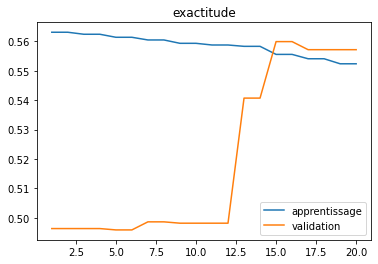

In [12]:
plt.title('exactitude')
plt.plot(range(1,21),exac_train,range(1,21),exac_test)
plt.legend(['apprentissage','validation'])
plt.show()

Avec l'indice <b>Exactitude</b> : on remarque avec K = 15 on a atteint son maximum

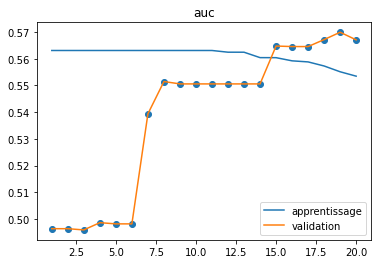

In [13]:
plt.title('auc')
plt.plot(range(1,21),auc_train,range(1,21),auc_test)
plt.scatter(range(1,21),auc_test)
plt.legend(['apprentissage','validation'])
plt.show()

Avec l'indice <b>AUC</b> : on remarque avec K = 15 on a atteint 0.0.56xxx proche son maximum

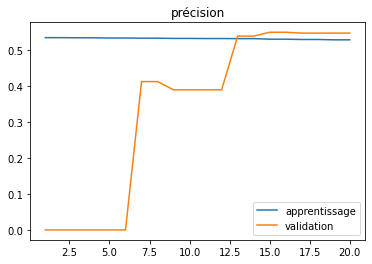

In [14]:
plt.title('précision')
plt.plot(range(1,21),preci_train,range(1,21),preci_test)
plt.legend(['apprentissage','validation'])
plt.show()

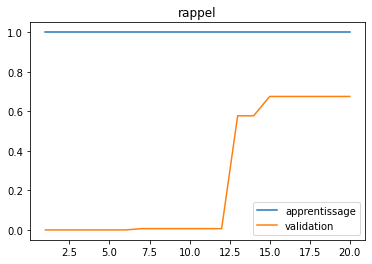

In [15]:
plt.title('rappel')
plt.plot(range(1,21),rappel_train,range(1,21),rappel_test)
plt.legend(['apprentissage','validation'])
plt.show()

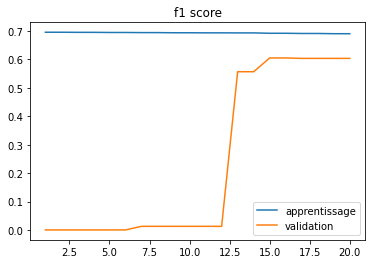

In [16]:
plt.title('f1 score')
plt.plot(range(1,21),f1score_train,range(1,21),f1score_test)
plt.legend(['apprentissage','validation'])
plt.show()

In [24]:
#KNN avec k15
data_clffinal=KNeighborsClassifier(n_neighbors=15)
data_clffinal.fit(data_train,y_train)
pred_final=data_clffinal.predict(data_train)
print(classification_report(y_train,pred_final))

              precision    recall  f1-score   support

           0       1.00      0.10      0.18      4381
           1       0.53      1.00      0.69      4381

    accuracy                           0.55      8762
   macro avg       0.76      0.55      0.43      8762
weighted avg       0.76      0.55      0.43      8762



<br> le <b>accuracy</b> de 0.55 et son <b>recall </b> ,<b>f1-score</b> de classe y = 0 sont relativement faibles.
==> Je prend K = 15.

# GridSearchCV en KNN

In [19]:
from sklearn.model_selection import GridSearchCV
grid_params = {
    'n_neighbors' : [3,5,11,19],
    'weights' : ['uniform','distance'],
    'metric' : ['euclidean','manhattan']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 1,
    cv= 3,
    n_jobs = -1
)

gs_res = gs.fit(data_train,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


In [20]:
gs_res.best_score_

0.5596892444727911

In [21]:
# Best n neighbors
gs_res.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=3, weights='distance')

In [22]:
gs_res.best_params_

{'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}

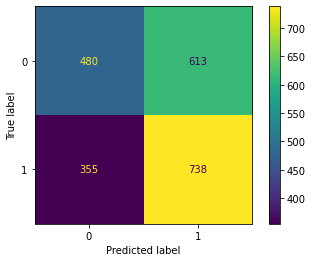

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, pred_test, labels=data_clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=data_clf.classes_)
disp.plot()
plt.show()